In [127]:
from scipy.stats import qmc
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [128]:
def ode_fcn(t, y, feed):
  # define parameters
    VCD = y[0]
    Glc = y[1]
    # growth rate
    mu = Glc/(5+Glc)
    # mass balances
    dVCD_dt = mu*VCD
    dGlc_dt = -(0.5*mu+0.05*Glc)*VCD+feed
    dy = [dVCD_dt, dGlc_dt]
    return dy

def run_experiment(VCD_0, Glc_0, feed, t_end):
    fun = lambda t, y: ode_fcn(t,y,feed)
    y0 = [VCD_0, Glc_0]
    t_span = np.arange(0, 0.5*round(2*t_end)+0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc


In [129]:
def ode_fcn_1st_hybrid(t, y, feed, g_mld, k_mld):
    # mass balances
    dVCD_dt = g_mld.predict(y.reshape(-1, 1).T)
    dGlc_dt = -k_mld.predict(y.reshape(-1, 1).T) + feed
    return [dVCD_dt, dGlc_dt]


def run_1st_hybrid(VCD_0, Glc_0, feed, t_end, g_mld, k_mld):
    fun = lambda t, y: ode_fcn_1st_hybrid(t, y, feed, g_mld, k_mld)
    y0 = np.array([VCD_0, Glc_0])
    t_span = np.arange(0, 0.5 * round(2 * t_end) + 0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc

In [130]:
def ode_fcn_2nd_hybrid(t, y,feed, g_mld,k_mld):
    # mass balances
    dVCD_dt = g_mld.predict(y.reshape(-1, 1).T)*y[0]
    dGlc_dt = -k_mld.predict(y.reshape(-1, 1).T)*y[0]+feed
    return [dVCD_dt, dGlc_dt]


def run_2nd_hybrid(VCD_0,Glc_0,feed,t_end,mu_mld,k_mld):
    fun = lambda t, y: ode_fcn_2nd_hybrid(t, y, feed, g_mld, k_mld)
    y0 = np.array([VCD_0, Glc_0])
    t_span = np.arange(0, 0.5 * round(2 * t_end) + 0.25, 0.25)
    sol = solve_ivp(fun, [t_span[0], t_span[-1]], y0, method='LSODA', t_eval=t_span, rtol=1e-6, atol=1e-6)
    t = sol.t.tolist()
    y = sol.y.T
    VCD = y[:, 0]
    Glc = y[:, 1]
    return t, VCD, Glc

# Hybrid Models

A simple model for cell expansion, accounting for the growth of viable cell density (VCD) and the consumption of glucose (Glc), is used to show how hybrid models are trained and can predict new experimental conditions.

Firstly, we will run the base experiment experiment:

**Base experiment**

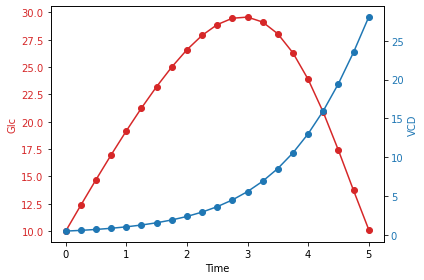

In [131]:
t, VCD, Glc = run_experiment(0.5,10,10,5)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Glc', color=color)
ax1.plot(t, Glc, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('VCD', color=color)  # we already handled the x-label with ax1
ax2.plot(t, VCD, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Create experimental design**

In [132]:
Nruns_train = 4
DoE_train = np.zeros((Nruns_train,3))
sampler = qmc.LatinHypercube(d=3)
DoE_nondim_train = 2*sampler.random(n=Nruns_train)-1
DoE_train[:, 0] = 2+1.5*DoE_nondim_train[:,0]
DoE_train[:, 1] = 20+10*DoE_nondim_train[:,1]
DoE_train[:, 2] = 30+25*DoE_nondim_train[:,2]

Run experiments:

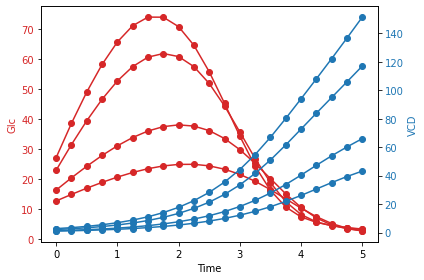

In [133]:
VCD = np.zeros((21, Nruns_train))
Glc = np.zeros((21, Nruns_train))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for nexp in range(Nruns_train):
    t, VCD[:,nexp],Glc[:,nexp] = run_experiment(DoE_train[nexp,0],DoE_train[nexp,1],DoE_train[nexp,2],5)
    
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Glc', color=color)
    ax1.plot(t, Glc[:, nexp], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2.set_ylabel('VCD', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, VCD[:, nexp], 'o-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Create test set and run experiments:

In [134]:
Nruns_test = 100
DoE_test = np.zeros((Nruns_test,3))
sampler = qmc.LatinHypercube(d=3)
DoE_nondim_test = 2*sampler.random(n=Nruns_test)-1
DoE_test[:, 0] = 2+1.5*DoE_nondim_test[:,0]
DoE_test[:, 1] = 20+10*DoE_nondim_test[:,1]
DoE_test[:, 2] = 30+25*DoE_nondim_test[:,2]
DoE_test.shape

VCD_test = np.zeros((21, Nruns_test))
Glc_test = np.zeros((21, Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test[:,nexp], Glc_test[:,nexp] = run_experiment(DoE_test[nexp,0],DoE_test[nexp,1], DoE_test[nexp,2],5)


## Train Black-box GP
In this section, we are training a "black-box" Gaussian process, which is directly linking the manipulated variables to the final VCD and the final Glc.

The scope of this exercize is to show that the good predictability of the hybrid models that are shown below in the script cannot be ascribed to the fitting capabilities of GPs.

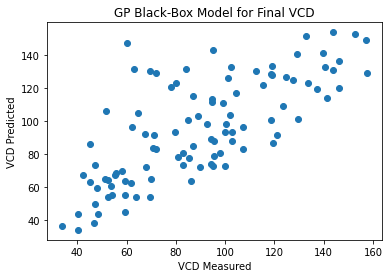

In [135]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(DoE_train, VCD[20, :])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(VCD_test[20,:], Glc_end_pred)
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('GP Black-Box Model for Final VCD')
plt.show()

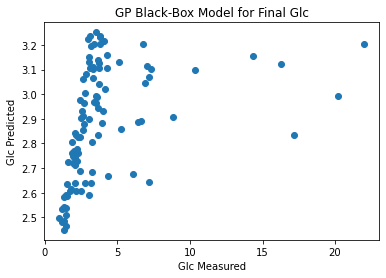

In [136]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=3).fit(DoE_train, Glc[20,:])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(Glc_test[20,:], Glc_end_pred)
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('GP Black-Box Model for Final Glc')
plt.show()

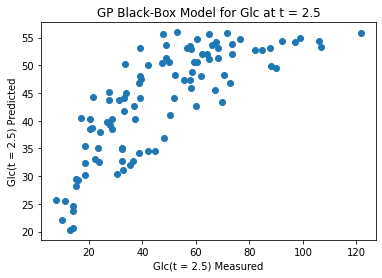

In [137]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=3).fit(DoE_train, Glc[10,:])
Glc_end_pred = gpr.predict(DoE_test)
plt.scatter(Glc_test[10,:], Glc_end_pred)
plt.ylabel('Glc(t = 2.5) Predicted')
plt.xlabel('Glc(t = 2.5) Measured')
plt.title('GP Black-Box Model for Glc at t = 2.5')
plt.show()

### My first Hybrid Model  

Let's suppose the following model: 

$$
\begin{aligned}
&\frac{\mathrm{dVCD}}{\mathrm{dt}}=g(\mathrm{VCD}, \mathrm{Glc}) \\
&\frac{\mathrm{dGlc}}{\mathrm{dt}}=-k(\mathrm{VCD}, \mathrm{Glc})+\text { feed }
\end{aligned}
$$

Let's use the inverse method to get the model. First, let's estimate the derivatives.


In [138]:
g = np.zeros((21, Nruns_train))
k = np.zeros((21, Nruns_train))
delta_t = t[1]-t[0]
g[0,:] = (VCD[1,:]-VCD[0,:])/delta_t
dGlcdt = (Glc[1,:]-Glc[0,:])/delta_t
k[0,:] = -dGlcdt+DoE_train[:,2].T
for nstep in range(1, 20):
    g[nstep,:] = 0.5*(VCD[nstep+1,:]-VCD[nstep-1,:])/delta_t
    dGlcdt = 0.5*(Glc[nstep+1,:]-Glc[nstep-1,:])/delta_t
    k[nstep,:] = -dGlcdt+DoE_train[:,2].T
g[20,:] = (VCD[20,:]-VCD[19,:])/delta_t
dGlcdt = (Glc[20,:]-Glc[19,:])/delta_t
k[20,:] = -dGlcdt+DoE_train[:,2].T

Let's plot the data:

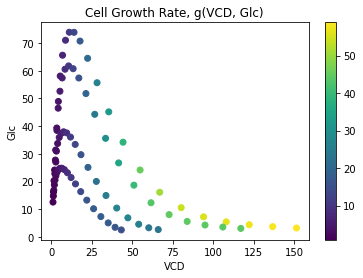

In [139]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=g.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, g(VCD, Glc)')
plt.colorbar()
plt.show()

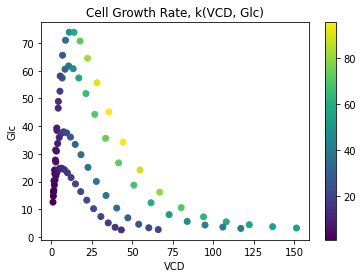

In [140]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=k.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, k(VCD, Glc)')
plt.colorbar()
plt.show()

Let's fit a model:

In [141]:
X = np.stack((VCD.flatten(), Glc.flatten()), axis=1)
g_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, g.flatten())
k_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, k.flatten())

Make prediction on the training set:

In [142]:
VCD_train_pred = np.zeros((21, Nruns_train))
Glc_train_pred = np.zeros((21, Nruns_train))
for nexp in range(Nruns_train):
    t,VCD_train_pred[:,nexp],Glc_train_pred[:,nexp] = run_1st_hybrid(DoE_train[nexp,0], DoE_train[nexp,1], DoE_train[nexp,2], 5, g_mld, k_mld)

Plot the fit of our model on a training experiment (1st hybrid):

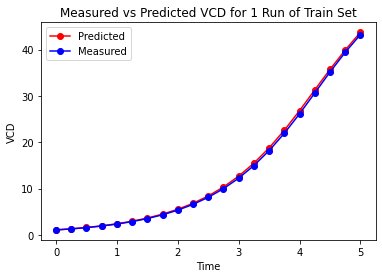

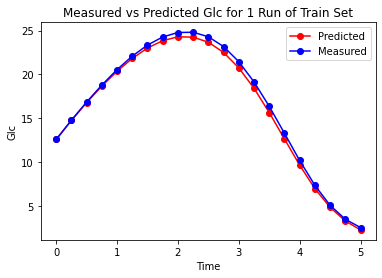

In [143]:
exp_no = 1
plt.plot(t, VCD_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of Train Set')
plt.show()

plt.plot(t, Glc_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of Train Set')
plt.show()

Plot YvsY in the training set for all times (1st hybrid):

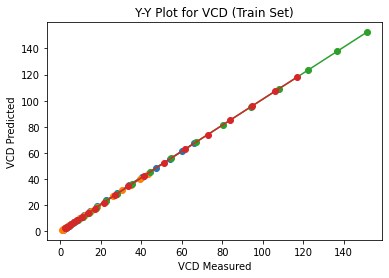

In [144]:
for nexp in range(Nruns_train):
    plt.plot(VCD[:, nexp],VCD_train_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Train Set)')
plt.show()

In [145]:
RMSE_VCD = np.sqrt(np.sum((VCD.flatten()-VCD_train_pred.flatten())**2)/Nruns_train)
RMSE_VCD

3.345880198061998

In [146]:
RMSE_VCD_rel = RMSE_VCD/np.std(VCD.flatten())
RMSE_VCD_rel

0.0955054820976624

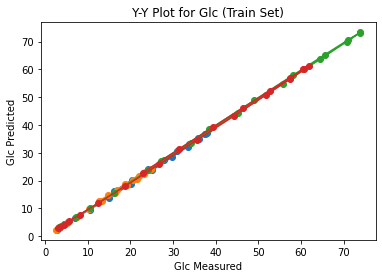

In [147]:
for nexp in range(Nruns_train):
    plt.plot(Glc[:, nexp],Glc_train_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Train Set)')
plt.show()

In [148]:
RMSE_Glc = np.sqrt(np.sum((Glc.flatten()-Glc_train_pred.flatten())**2)/Nruns_train)
RMSE_Glc

2.7426072835956394

In [149]:
RMSE_Glc_rel = RMSE_Glc/np.std(Glc.flatten())
RMSE_Glc_rel

0.13700657669008634

**Make prediction on the test set (1st hybrid):**

In [150]:
VCD_test_pred = np.zeros((21,Nruns_test))
Glc_test_pred = np.zeros((21,Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test_pred[:,nexp], Glc_test_pred[:,nexp] = run_1st_hybrid(DoE_test[nexp,0], DoE_test[nexp,1], DoE_test[nexp,2], 5, g_mld, k_mld)


Plot how the trained model fits on a test experiment (1st hybrid):

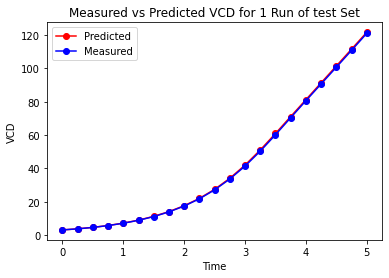

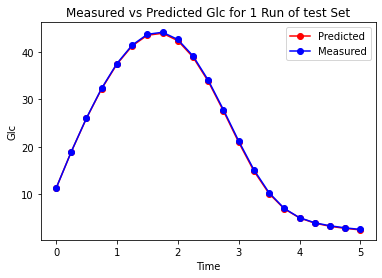

In [151]:
exp_no = 1
plt.plot(t, VCD_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of test Set')
plt.show()

plt.plot(t, Glc_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of test Set')
plt.show()

Plot YvsY in test set for all times (1st hybrid):

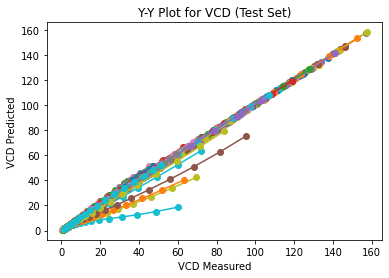

In [152]:
for nexp in range(Nruns_test):
    plt.plot(VCD_test[:, nexp], VCD_test_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Test Set)')
plt.show()

In [153]:
RMSE_VCD = np.sqrt(np.sum((VCD_test.flatten()-VCD_test_pred.flatten())**2)/Nruns_test)
RMSE_VCD

11.10879404845097

In [154]:
RMSE_VCD_rel = RMSE_VCD/np.std(VCD_test.flatten())
RMSE_VCD_rel

0.35409615979657605

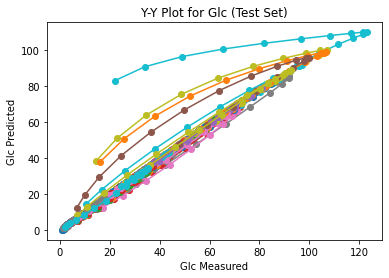

In [155]:
for nexp in range(Nruns_test):
    plt.plot(Glc_test[:, nexp], Glc_test_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Test Set)')
plt.show()

In [156]:
RMSE_Glc = np.sqrt(np.sum((Glc_test.flatten()-Glc_test_pred.flatten())**2)/Nruns_test)
RMSE_Glc

15.18734953709771

In [157]:
RMSE_Glc_rel = RMSE_Glc/np.std(Glc_test.flatten())
RMSE_Glc_rel

0.6321872947167935

#### My second Hybrid Model

Let's suppose the following model:
$$
\begin{aligned}
&\frac{\mathrm{dVCD}}{\mathrm{dt}}=\mu(\mathrm{VCD}, \mathrm{Glc}) \cdot \mathrm{VCD} \\
&\frac{\mathrm{dGlc}}{\mathrm{dt}}=-k(\mathrm{VCD}, \mathrm{Glc}) \cdot \mathrm{VCD}+\text { feed }
\end{aligned}
$$

As before, let's use the inverse method to get the model. First, let's estimate the derivatives.

In [158]:
g = np.zeros((21,Nruns_train))
k = np.zeros((21,Nruns_train))
delta_t = t[1]-t[0]
dVCDdt = (VCD[1,:]-VCD[0,:])/delta_t
g[0,:] = dVCDdt/VCD[0,:]
dGlcdt = (Glc[1,:]-Glc[0,:])/delta_t
k[0,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[1,:]
for nstep in range(1,20):
    dVCDdt = 0.5*(VCD[nstep+1,:]-VCD[nstep-1,:])/delta_t
    g[nstep,:] = dVCDdt/VCD[nstep,:]
    dGlcdt = 0.5*(Glc[nstep+1,:]-Glc[nstep-1,:])/delta_t
    k[nstep,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[nstep,:]
dVCDdt = (VCD[20,:]-VCD[19,:])/delta_t
g[20,:] = dVCDdt/VCD[20,:]
dGlcdt = (Glc[20,:]-Glc[19,:])/delta_t
k[20,:] = (-dGlcdt+DoE_train[:,2].T)/VCD[20,:]

Let's plot the data:

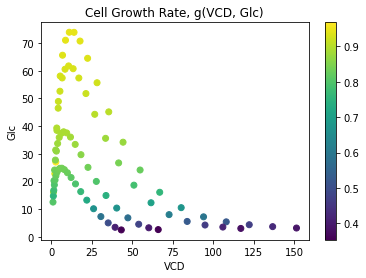

In [159]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=g.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, g(VCD, Glc)')
plt.colorbar()
plt.show()

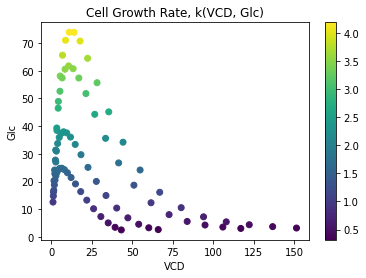

In [160]:
plt.scatter(VCD.flatten(), Glc.flatten(), c=k.flatten(), cmap='viridis')
plt.ylabel('Glc')
plt.xlabel('VCD')
plt.title('Cell Growth Rate, k(VCD, Glc)')
plt.colorbar()
plt.show()

Let's fit a model:

In [161]:
X = np.stack((VCD.flatten(), Glc.flatten()), axis=1)
g_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, g.flatten())
k_mld = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.0, n_restarts_optimizer=3).fit(X, k.flatten())

Make prediction on the training set:

In [162]:
VCD_train_pred = np.zeros((21, Nruns_train))
Glc_train_pred = np.zeros((21, Nruns_train))
for nexp in range(Nruns_train):
    t, VCD_train_pred[:,nexp], Glc_train_pred[:,nexp] = run_2nd_hybrid(DoE_train[nexp,0], DoE_train[nexp,1], DoE_train[nexp,2], 5, g_mld, k_mld)

Plot the fit of our model on a training experiment (2nd hybrid):

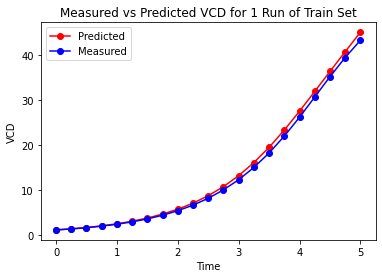

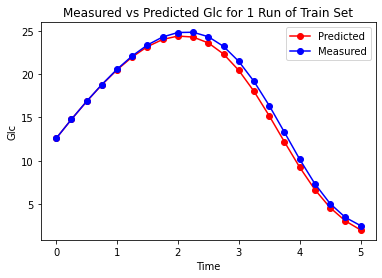

In [163]:
exp_no = 1
plt.plot(t, VCD_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of Train Set')
plt.show()

plt.plot(t, Glc_train_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of Train Set')
plt.show()

Plot YvsY in training set for all times (2nd hybrid):

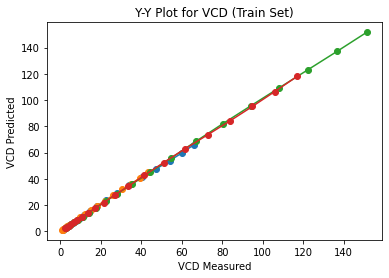

In [164]:
for nexp in range(Nruns_train):
    plt.plot(VCD[:, nexp],VCD_train_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Train Set)')
plt.show()

In [165]:
RMSE_VCD = np.sqrt(np.sum((VCD.flatten()-VCD_train_pred.flatten())**2)/Nruns_train)
RMSE_VCD

3.252287341832026

In [166]:
RMSE_VCD_rel = RMSE_VCD/np.std(VCD.flatten())
RMSE_VCD_rel

0.09283394865174939

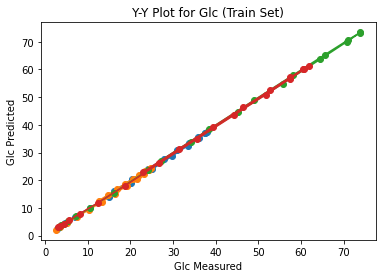

In [167]:
for nexp in range(Nruns_train):
    plt.plot(Glc[:, nexp],Glc_train_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Train Set)')
plt.show()

In [168]:
RMSE_Glc = np.sqrt(np.sum((Glc.flatten()-Glc_train_pred.flatten())**2)/Nruns_train)
RMSE_Glc

2.503136251135782

In [169]:
RMSE_Glc_rel = RMSE_Glc/np.std(Glc.flatten())
RMSE_Glc_rel

0.12504383358428087

**Make prediction on the test set (2nd hybrid):**

In [170]:
VCD_test_pred = np.zeros((21,Nruns_test))
Glc_test_pred = np.zeros((21,Nruns_test))
for nexp in range(Nruns_test):
    t, VCD_test_pred[:,nexp], Glc_test_pred[:,nexp] = run_2nd_hybrid(DoE_test[nexp,0], DoE_test[nexp,1], DoE_test[nexp,2], 5, g_mld, k_mld)

Plot how the model fits on a test experiment (2nd hybrid):

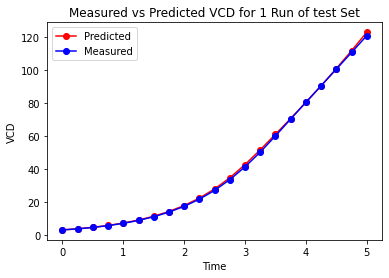

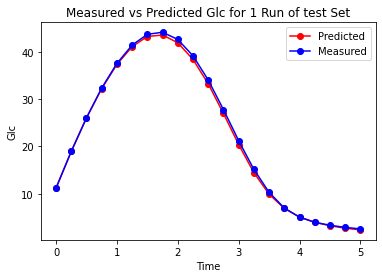

In [171]:
exp_no = 1
plt.plot(t, VCD_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, VCD_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('VCD')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted VCD for 1 Run of test Set')
plt.show()

plt.plot(t, Glc_test_pred[:, exp_no], 'o-', color='r', label='Predicted')
plt.plot(t, Glc_test[:, exp_no], 'o-', color='b', label='Measured')
plt.ylabel('Glc')
plt.xlabel('Time')
plt.legend()
plt.title('Measured vs Predicted Glc for 1 Run of test Set')
plt.show()

Plot YvsY in the test set for all times (2nd hybrid):

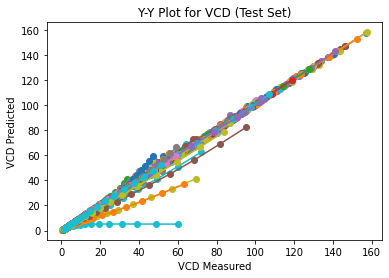

In [172]:
for nexp in range(Nruns_test):
    plt.plot(VCD_test[:, nexp], VCD_test_pred[:, nexp], 'o-')
    
plt.ylabel('VCD Predicted')
plt.xlabel('VCD Measured')
plt.title('Y-Y Plot for VCD (Test Set)')
plt.show()

In [173]:
RMSE_VCD = np.sqrt(np.sum((VCD_test.flatten()-VCD_test_pred.flatten())**2)/Nruns_test)
RMSE_VCD

12.568297666917015

In [174]:
RMSE_VCD_rel = RMSE_VCD/np.std(VCD_test.flatten())
RMSE_VCD_rel

0.4006182777019032

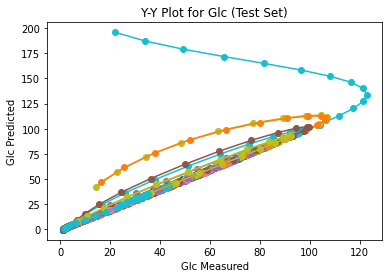

In [175]:
for nexp in range(Nruns_test):
    plt.plot(Glc_test[:, nexp], Glc_test_pred[:, nexp], 'o-')
    
plt.ylabel('Glc Predicted')
plt.xlabel('Glc Measured')
plt.title('Y-Y Plot for Glc (Test Set)')
plt.show()

In [176]:
RMSE_Glc = np.sqrt(np.sum((Glc_test.flatten()-Glc_test_pred.flatten())**2)/Nruns_test)
RMSE_Glc

33.73987735480946

In [177]:
RMSE_Glc_rel = RMSE_Glc/np.std(Glc_test.flatten())
RMSE_Glc_rel

1.4044532086992134